# Create a Heiarchcical Model

The Knowledpack library we create can also be a combination of several knowledpacks that you have already built. In fact, it can have an arbitrary number of different models so long as the device you are using has enough space to use them. In this tutorial we give an example of building a heiarchical model using the gesture data. This model will consist of 3 models in total with the goal of predicting gestures A, D, M, L and U from the gesture project. In the Parent Model we will separate our data into two groups, AD and MLU and build a model that can make a prediction as to which group they are in. Then we will build a model that can tell the difference between A and D, and a thrid model that will distinguish between M, L and U. The binary we create will optimize the knowledpack to reuse code and resources where possible combining all three models in a decision tree structure.

# Connect to Server

In [2]:
import sys
from sensiml import SensiML
import pandas as pd
import numpy as np
from sensiml.widgets import *
dsk = SensiML()

dsk.project = 'Gesture Demo'
dsk.pipeline = "Heiarchical Pipeline"

Sandbox Heiarchical Pipeline does not exist, creating a new sandbox.


## Create a queries for each node model
Lets create a query for each of the nodes in our model. Lets create 
* one query that selects A,D,L,M,U. 
* One query that selects A,D
* One query that selects L,M,U

We will use the query widget. Create a name for your query- it helps to pick one that is meaningful to the type of data you are going to pull in such as Gesture Query - ADMLU - Dec 29-2017. But for now lets use ADLMU. You will will use this query in next section to pull the data into your pipeline.
For the inputs select the following from the query widget.

 * Query Name: Gesture Query - ADMLU
 * Segmenter: Segment Builder Result
 * Label Column: Gesture
 * Metadata Columns: Subject
 * Sensor Columns: Select all of them
 * Metadata Filter [Gesture] in [A,D,L,M,U]

In [ ]:
QueryWidget(dsk).create_widget()

# Create Parent Model

## Generate Feature Vectors for the selected Query

In [6]:
dsk.pipeline.reset()

dsk.pipeline.set_input_query("ADLMU")

dsk.pipeline.add_transform("Magnitude", params={"input_columns":[u'AccelerometerX', u'AccelerometerZ']}, overwrite=False)

sensor_columns = [u'AccelerometerY', u'AccelerometerX', u'AccelerometerZ', u'GyroscopeX', u'GyroscopeY', u'GyroscopeZ',
                 u'Magnitude_ST_0000']

dsk.pipeline.add_feature_generator([ {'subtype_call': 'Time', 'params': {'sample_rate': 100}},
                                            {'subtype_call': 'Rate of Change'},
                                            {'subtype_call': 'Statistical'},
                                            {'name':'Convolution Avg', 'params':{"columns": sensor_columns, "new_length": 9}},
                                            ],
                                            function_defaults={'columns': sensor_columns},
                                           )

dsk.pipeline.add_transform("Min Max Scale", params={"min_bound":0, "max_bound":255, "pad":2})

## Combine Features into sub groups for prediction

Here we will combine our 5 features into two groups to make predictions on. In group one we will combine the segments from A,D and in group 2 we will combine the segments M, U and L. Afterwards we will apply a series of feature selectors to reduce the number of features to the most relavent/separable.

In [7]:
dsk.pipeline.add_transform("Combine Labels", params={"combine_labels": {'Group1':['A','D'],'Group2':['M','U','L']}})

In [8]:
dsk.pipeline.add_feature_selector([{'name':'Information Gain', 'params':{"feature_number": 2, "target_sensor_weight": 0.9}},
                                   {'name':'Recursive Feature Elimination', 'params':{"method":"Log R", "number_of_features":8}}
                                  ],
                                  params = {"number_of_features":4})

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: ADLMU                     		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: C

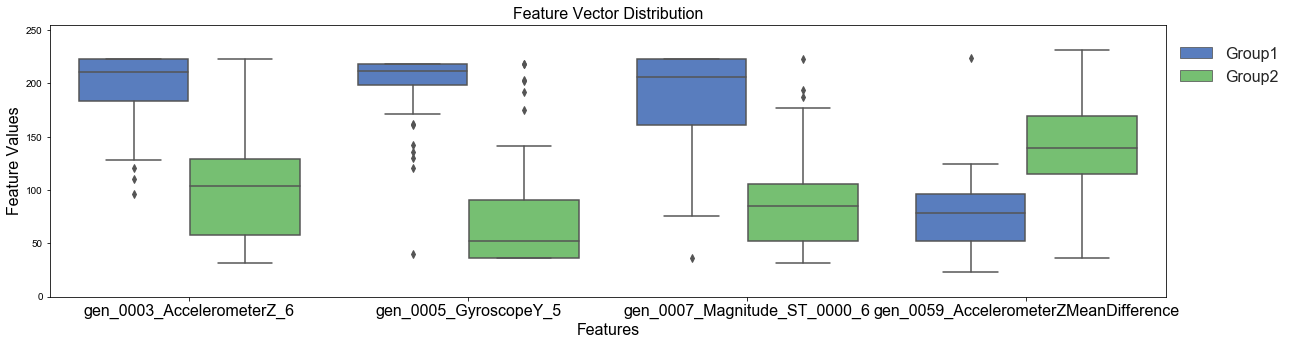

In [9]:
features, s = dsk.pipeline.execute()
dsk.pipeline.visualize_features(feature_vector=features)

## Build a model using KNN

We will now build a model to recognize these two classes. We will use the KNN classifier which will always return the closest result. Unlike RBF, which will only return results within the AIF distance otherwise it returns unknown.

In [10]:
dsk.pipeline.set_classifier("PVP", params={"distance_mode":"L1", "classification_mode":"KNN", "max_aif":156, "min_aif":5})
dsk.pipeline.set_validation_method("Stratified K-Fold Cross-Validation", params={"number_of_folds": 4})
dsk.pipeline.set_training_algorithm("Hierarchical Clustering with Neuron Optimization", params={"number_of_neurons":46})
dsk.pipeline.set_tvo({'validation_seed':0})

r,s = dsk.pipeline.execute()
model = r.configurations[0].models[0]
r.summarize()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: ADLMU                     		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: C

## Visualize the features and neuron placement

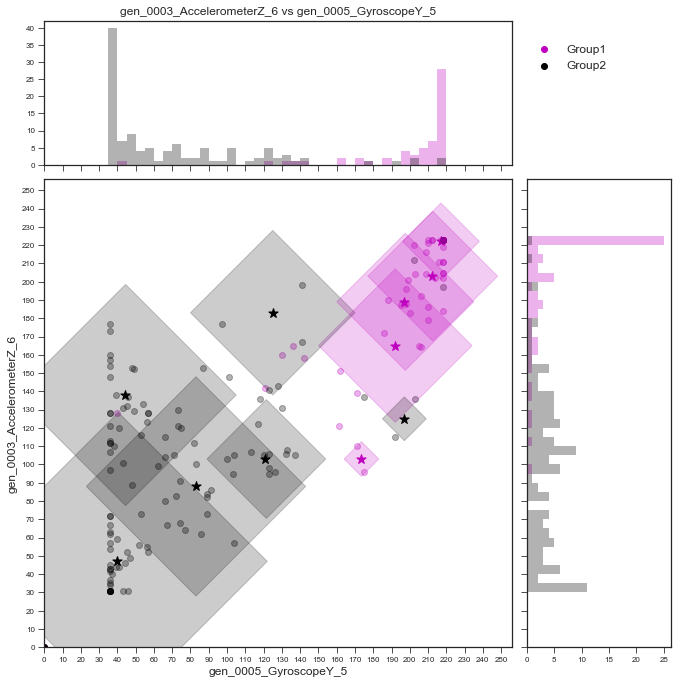

In [11]:
dsk.pipeline.visualize_neuron_array(model, features, features.columns[3], [features.columns[4]])

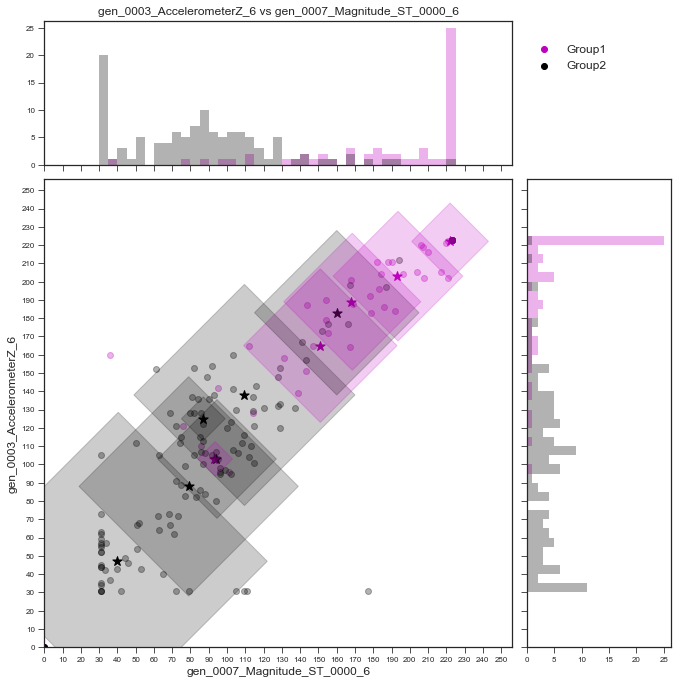

In [12]:
dsk.pipeline.visualize_neuron_array(model, features, features.columns[3], [features.columns[5]])

## Test the KP against a capture file

Because we have grouped our data into two categories. We would expect any gesture that is A or D to return classification 1, and any gesture that is M,U or L to be recognized as classification 2. Let us check that this is the case with one of our files captured previously in the DCL.

In [26]:
dsk.list_captures().head()

,Name
0,Justin_U 2017-12-04 10_37_33.csv
1,Justin_D 2017-12-04 10_35_42.csv
2,Marc_L 2017-11-30 11_44_26.csv
3,Marc_M 2017-11-30 12_12_24.csv
4,Rogers_M 2017-12-04 13_20_47.csv


In [25]:
rr,ss = model.knowledgepack.recognize_signal(capture="Justin_U 2017-12-04 10_37_33.csv")
rr


Checking for Results:

Pipeline Running... Run Time: 0 sec.
.
Results Retrieved.


,DistanceVector,NIDVector,CategoryVector,MappedCategoryVector,SegmentID
0,[106],[1],[2],[Group2],0
1,[101],[1],[2],[Group2],1
2,[146],[2],[2],[Group2],2
3,[109],[1],[2],[Group2],3
4,[9],[3],[1],[Group1],4
5,[121],[2],[2],[Group2],5
6,[129],[1],[2],[Group2],6


## Save the KP

In [13]:
model.knowledgepack.save('Parent-ADMLU')

Knowledgepack name updated.


# Create Submodel A, D


## Generate features for A and D segments

In [14]:
dsk.pipeline.reset(delete_cache=True)

dsk.pipeline.set_input_query("AD")

dsk.pipeline.add_transform("Magnitude", params={"input_columns":[u'AccelerometerX', u'AccelerometerZ']}, overwrite=False)

dsk.pipeline.add_feature_generator([        {'subtype_call': 'Time', 'params': {'sample_rate': 100}},
                                            {'subtype_call': 'Rate of Change'},
                                            {'subtype_call': 'Statistical'},
                                            {'name':'Convolution Avg', 'params':{"columns": sensor_columns, "new_length": 9}},
                                            ],
                                            function_defaults={'columns': sensor_columns},
                                           )

dsk.pipeline.add_transform("Min Max Scale", params={"min_bound":0, "max_bound":255, "pad":2})

dsk.pipeline.add_feature_selector([{'name':'Information Gain', 'params':{"feature_number": 4, "target_sensor_weight": 0.9}},
                                   {'name':'Recursive Feature Elimination', 'params':{"method":"Log R", "number_of_features":5}}
                                  ],
                                  params = {"number_of_features":4})


Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: AD                        		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: s

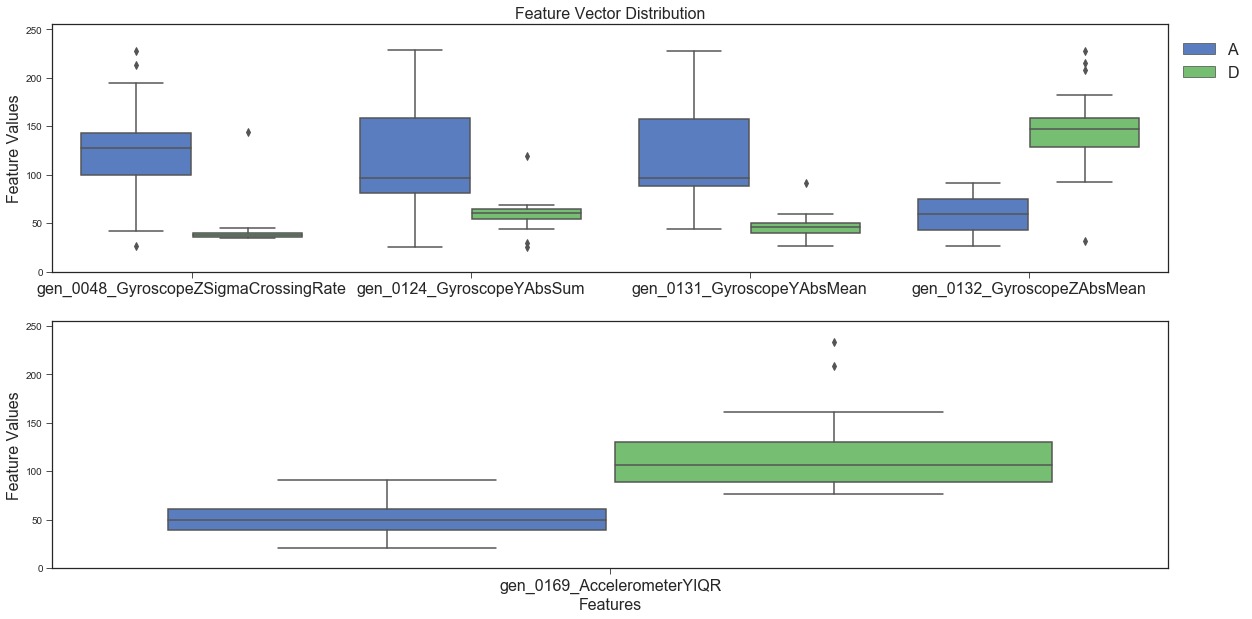

In [15]:
features, s = dsk.pipeline.execute()
dsk.pipeline.visualize_features(feature_vector=features)

## Generate A model for A and D using RBF

In [16]:
dsk.pipeline.set_classifier("PVP", params={"distance_mode":"L1", "classification_mode":"RBF", "max_aif":156, "min_aif":5})
dsk.pipeline.set_validation_method("Recall")
dsk.pipeline.set_training_algorithm("Hierarchical Clustering with Neuron Optimization", params={"number_of_neurons":46})
dsk.pipeline.set_tvo({'validation_seed':0})

r,s = dsk.pipeline.execute()
model = r.configurations[0].models[0]
r.summarize()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: AD                        		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: s

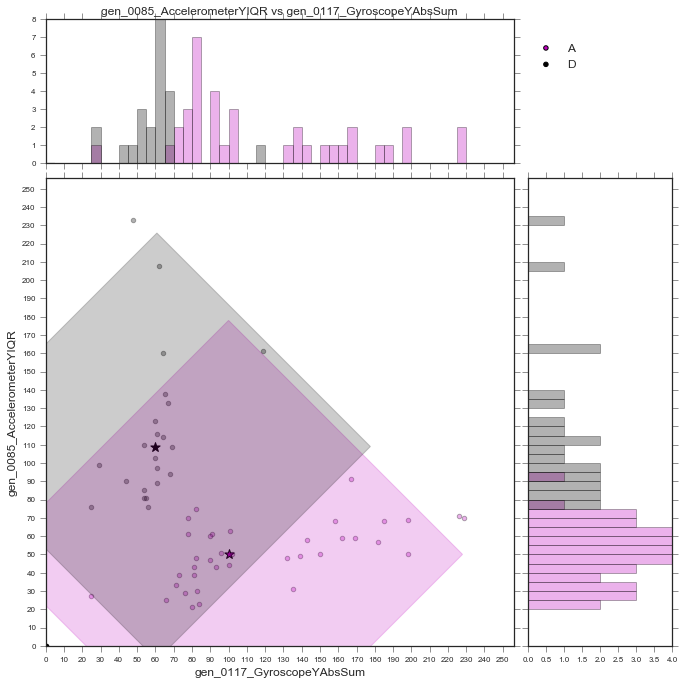

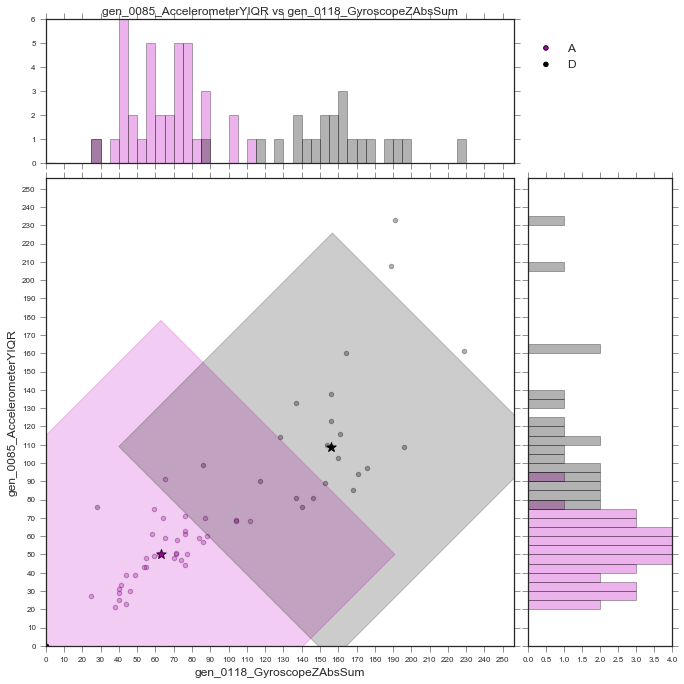

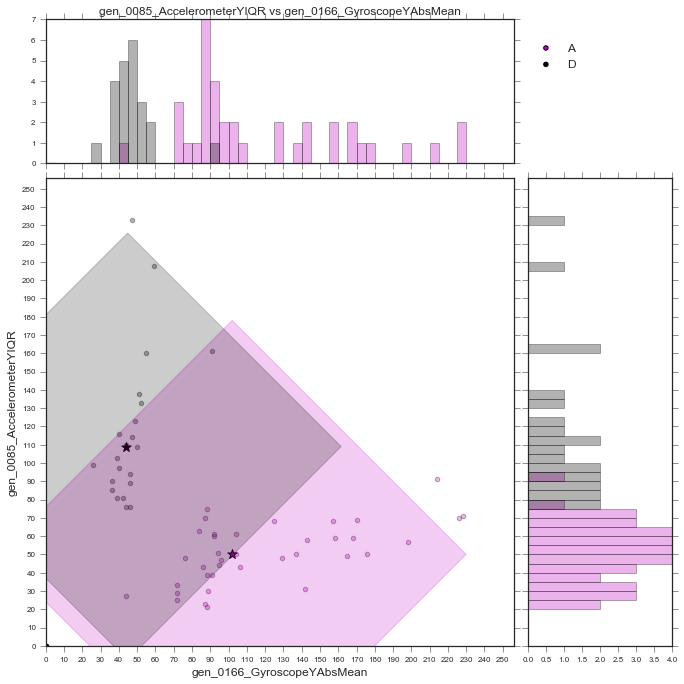

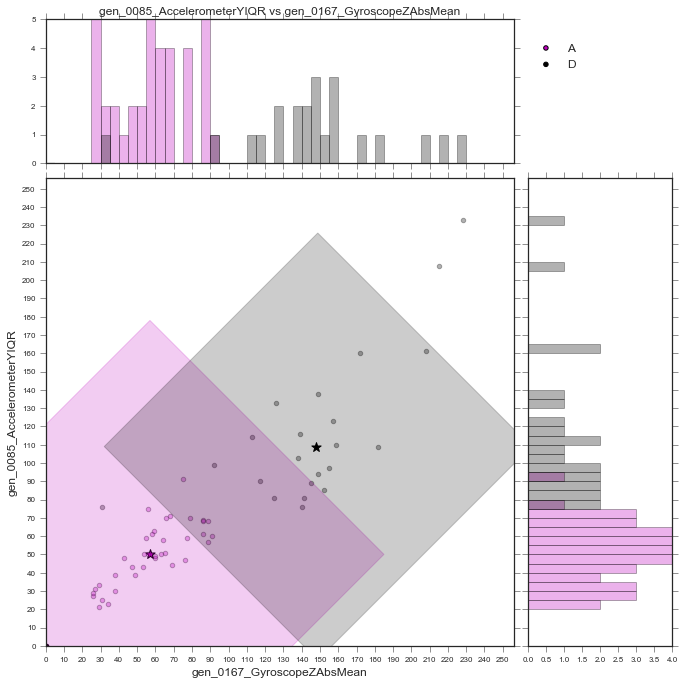

In [20]:
# a list of columns can also be passed in as the secon parameter to the visualize_neuron_array
dsk.pipeline.visualize_neuron_array(model, features, features.columns[3], features.columns[4:])

In [17]:
model.knowledgepack.save('AD')

Knowledgepack name updated.


# Create SubModel M,L,U

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: MLU                       		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: s

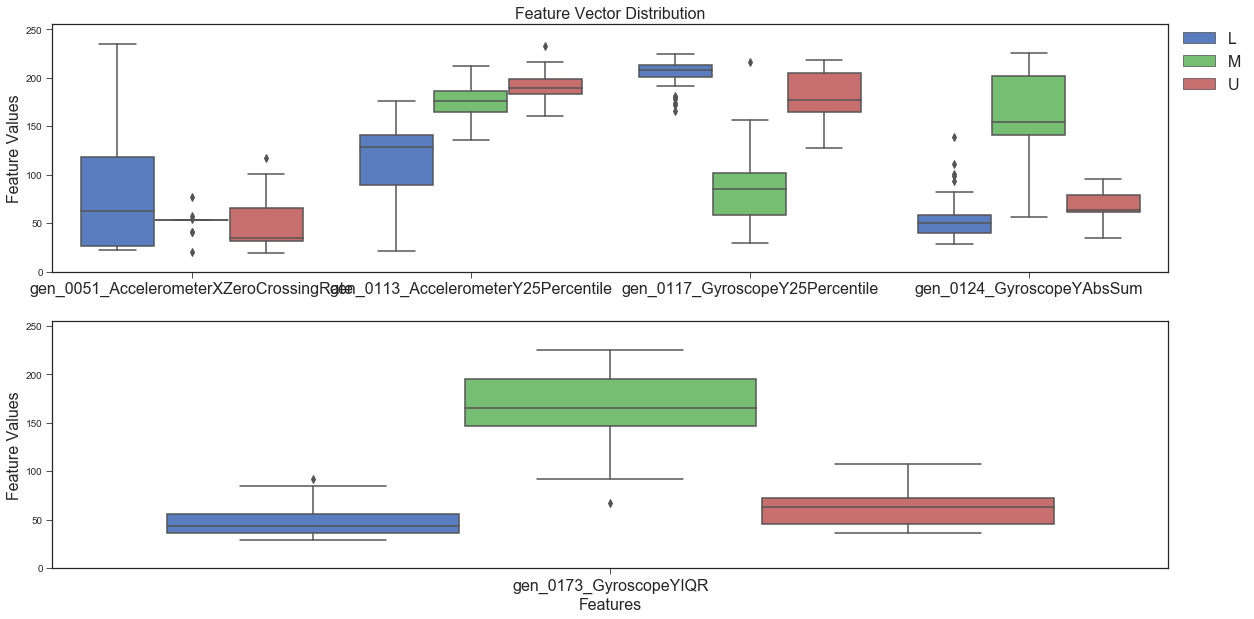

In [18]:
dsk.pipeline.reset(delete_cache=True)

dsk.pipeline.set_input_query("MLU")

dsk.pipeline.add_transform("Magnitude", params={"input_columns":[u'AccelerometerX', u'AccelerometerZ']}, overwrite=False)

dsk.pipeline.add_feature_generator([        {'subtype_call': 'Time', 'params': {'sample_rate': 100}},
                                            {'subtype_call': 'Rate of Change'},
                                            {'subtype_call': 'Statistical'},
                                            {'name':'Convolution Avg', 'params':{"columns": sensor_columns, "new_length": 9}},
                                            ],
                                            function_defaults={'columns': sensor_columns},
                                           )

dsk.pipeline.add_transform("Min Max Scale", params={"min_bound":0, "max_bound":255, "pad":2})

dsk.pipeline.add_feature_selector([{'name':'Information Gain', 'params':{"feature_number": 4, "target_sensor_weight": 0.9}},
                                   {'name':'Recursive Feature Elimination', 'params':{"method":"Log R", "number_of_features":5}}
                                  ],
                                  params = {"number_of_features":4})

features, s = dsk.pipeline.execute()
dsk.pipeline.visualize_features(feature_vector=features)

In [19]:
dsk.pipeline.set_classifier("PVP", params={"distance_mode":"L1", "classification_mode":"RBF", "max_aif":156, "min_aif":5})
dsk.pipeline.set_validation_method("Recall")
dsk.pipeline.set_training_algorithm("Hierarchical Clustering with Neuron Optimization", params={"number_of_neurons":46})
dsk.pipeline.set_tvo({'validation_seed':0})

r,s = dsk.pipeline.execute()
model = r.configurations[0].models[0]
r.summarize()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: MLU                       		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: s

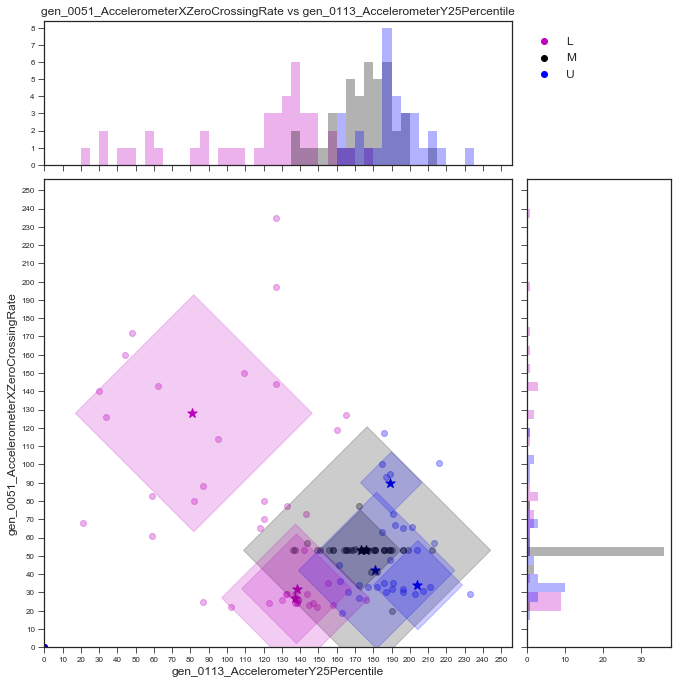

In [20]:
dsk.pipeline.visualize_neuron_array(model, features, features.columns[3], [features.columns[4]])

In [21]:
model.knowledgepack.save('MLU')

Knowledgepack name updated.


# Download a heirarchichal model into a knowledpack 

In [22]:
dsk.pipeline.list_knowledgepacks()

,Name,Project,Pipeline,kp_uuid
0,MLU,Gesture Demo,Heiarchical Pipeline,21fd6712-98d0-42dd-bc92-6aefd87ab401
1,AD,Gesture Demo,Heiarchical Pipeline,1ec982f3-ecb1-4959-baec-b6f3418b3f96
2,Parent-ADMLU,Gesture Demo,Heiarchical Pipeline,3492bae8-eb65-4166-af74-8cb6c4d68e21


### Description of model creation language

The hiearchical download widget is similar to the regular download widget except it allows you to add 1 level of nodes. For the Parent Model select model ADMLU. Then add the two submodels MLU and AD. For the output of group 1 for the parent model, select model AD. For group 2, select MLU. 

In [ ]:
HiearchicalWidget(dsk).create_widget()